In [215]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [216]:
import matplotlib.pyplot as plt
import jax.numpy as jnp
%matplotlib notebook

In [217]:
# from jax.config import config
# We need 64 bit floats so that solving for Te (Egedal et al) remains stable for a wide range
# config.update("jax_enable_x64", True)

# ## Values / JAX variables to optimize for
values = {
    'Eb': 1000.,
    'beta': 0.8,
    'B_pm': 30.,
    'B_p': 6.,
    'r_b': 0.25,
    'L_p': 10.,
    'p_aux': 0.0,  # this is in addition to synchotrfrom tqdm.notebook import tqdmon losses (which are calculated separately)
    'T_frac': 0.5,
    'Tep_fudge': 0.5,  # this should remain constant

    'B_cc': 1.5,
    'n_ccr': 0.25,
    'Ti_ccr': 1.0,
    'Te_ccr': 1.0,
    'L_cc': 20.0,

    # efficiencies should remain constant
    'Ef_DEC': 0.7,
    'Ef_TE': 0.5,
    'Ef_ECH': 0.6,
    'Ef_NBI': 0.6,
    'Ef_RF': 0.9,

    # engineering parameters remaining constant (for now)
    'd_blanket': 0.6,
    'd_vv': 0.2,
    'a_wall_r': 1.1,
    'cost_HTS_kAm': 1e-4,  # in megadollars (M$)
    'coil_spacing_cc': 1.0,  # in meters

    # physical quantities that are remaining constant for simplicity
    'mu': 2.5,
    'Z_eff': 1.13,
    'I_cooling': 0.0
}

# ## Flags
flags = {
    # assumes Ti_plug = 2/3 E_inj and Te_plug = 0.09 log(Rm/(sqrt(1-beta))^0.4)
    'simple_temps': False,
    'DD_cat': True,  # assumes DD fusion products are burned instantly. Is there any reason to turn this off?
    'field_reg_alphas': False,  # Regularize midplane field strengths via an alpha particle gyroradii heuristic
    'field_reg_Bohm': False,  # Regularize midplane field via Bohm diffusion heuristic
    'cc_aux_ECH': True,  # Use ECH to replace tandem mirror axial losses
}

# Need to do this horrible, horrible thing so that all the variables are in the same namespace.
# I could class-ify everything but that would require adding "self" or "global" into a bunch of
#   variables which would be super cluttered.
exec(open('mirror_physics_setup.py').read())
exec(open('optimization_setup.py').read())
from tqdm.notebook import tqdm

In [218]:
values_to_opt = values.copy()
num_values = 8

values_to_opt['L_p'] = jnp.ones(num_values) * values_to_opt['L_p']
values_to_opt['T_frac'] = jnp.ones(num_values) * values_to_opt['T_frac']
values_to_opt['Tep_fudge'] = jnp.ones(num_values) * values_to_opt['Tep_fudge']
values_to_opt['Z_eff'] = jnp.ones(num_values) * values_to_opt['Z_eff']
values_to_opt['mu'] = jnp.ones(num_values) * values_to_opt['mu']
values_to_opt['beta'] = jnp.ones(num_values) * values_to_opt['beta']
values_to_opt['r_b'] = jnp.ones(num_values) * values_to_opt['r_b']
values_to_opt['Eb'] = jnp.ones(num_values) * values_to_opt['Eb']

values_to_opt['B_p'] = jnp.ones(num_values) * 6.0
values_to_opt['B_pm'] = jnp.linspace(7, 20, num_values)
values_to_opt['p_aux'] = jnp.zeros(num_values)

# values_to_opt['I_cooling'] = jnp.zeros(num_values)

# Optimize with respect to the following:
# opt_symbol_list = [B_pm, B_p, r_b, L_p, T_frac, Eb]
opt_symbol_list = [B_pm, B_p]
cost_function = -Q_plug + 1 / B_p

simple_Q_opt = Optimizer(cost_function, opt_symbol_list, values_to_opt, flags)

Compiling JAX functions...


In [198]:
simple_Q_opt.reset_runs()

In [219]:
simple_Q_opt.run(num_iterations=1000, momentum=False, step_size=1e0);

  0%|          | 0/1000 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


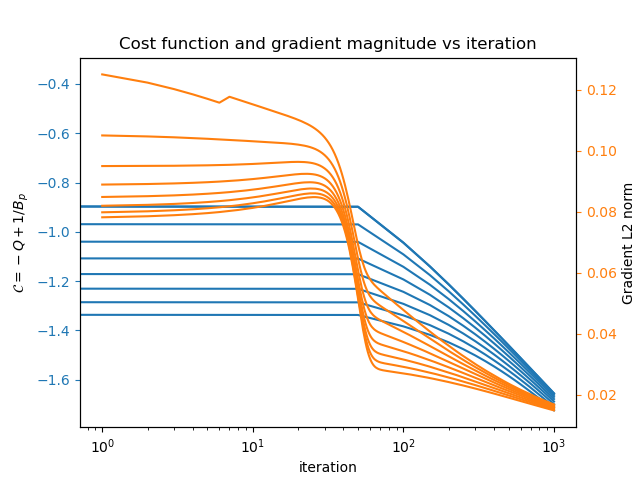

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Cost function and gradient magnitude vs iteration')

In [336]:
# print(jnp.array(simple_Q_opt.evaluate(0, 1001, 50))[:, 0])

fig, axQ = plt.subplots()
axQ.plot(np.arange(0, 1001, 50), jnp.array(simple_Q_opt.evaluate(0, 1001, 50))[:, 0:], color="#1f77b4")
axQ.plot(np.arange(0, 1001, 50), jnp.array(simple_Q_opt.evaluate(0, 1001, 50))[:, 0], label='$-Q + 1/B_p$', color="#1f77b4")
axQ.tick_params(colors="#1f77b4", axis='y')
axGrad = axQ.twinx()
axGrad.plot(np.arange(1, 1001), np.sqrt(np.sum((np.array(simple_Q_opt.loop_gradients) * simple_Q_opt.opt_idx_mask) ** 2, axis=1))[:, 1:],
            color='#ff7f0e')
axGrad.plot(np.arange(1, 1001), np.sqrt(np.sum((np.array(simple_Q_opt.loop_gradients) * simple_Q_opt.opt_idx_mask) ** 2, axis=1))[:, 0],
            color='#ff7f0e', label='grad l2 norm')
axGrad.tick_params(colors="#ff7f0e", axis='y')
axQ.set_xlabel('iteration')
axQ.set_ylabel('$\mathcal{C} = -Q + 1/B_p$')
axGrad.set_ylabel('Gradient L2 norm')

axGrad.set_xscale('log')
axQ.set_xscale('log')

# axGrad.set_yscale('log')
# axQ.set_yscale('log')

axGrad.set_xlim((0.712, 1.4e3))
axQ.set_xlim((0.712, 1.4e3))

# fig.legend()
axQ.set_title('Cost function and gradient magnitude vs iteration')
# axGrad.legend()
# plt.savefig('simple_Q_cost_paper.pdf')

In [222]:
idx_to_print = 0
print("symbol \t value_i \t value_f \t RMS grad")
for i in range(len(simple_Q_opt.symbol_list)):
    print(simple_Q_opt.symbol_list[i].name + ":\t {:.4e}".format(simple_Q_opt.loop_values[0][i, idx_to_print]) + ":\t {:.4e}".format(
        simple_Q_opt.loop_values[-1][i, idx_to_print]), "\t {:.4e}".format(np.sqrt(np.sum(np.array(simple_Q_opt.loop_gradients[0:-1]) ** 2, axis=0))[i, idx_to_print]))

symbol 	 value_i 	 value_f 	 RMS grad
T_frac:	 5.0000e-01:	 5.0000e-01 	 0.0000e+00
beta:	 8.0000e-01:	 8.0000e-01 	 0.0000e+00
L_p:	 1.0000e+01:	 1.0000e+01 	 0.0000e+00
Z_eff:	 1.1300e+00:	 1.1300e+00 	 0.0000e+00
Tep_fudge:	 5.0000e-01:	 5.0000e-01 	 0.0000e+00
p_aux:	 0.0000e+00:	 0.0000e+00 	 0.0000e+00
B_pm:	 7.0000e+00:	 3.5770e+01 	 1.0110e+00
mu:	 2.5000e+00:	 2.5000e+00 	 0.0000e+00
r_b:	 2.5000e-01:	 2.5000e-01 	 0.0000e+00
B_p:	 6.0000e+00:	 2.0059e+00 	 5.2533e-01
Eb:	 1.0000e+03:	 1.0000e+03 	 0.0000e+00


In [212]:
[sym.name for sym in simple_Q_opt.symbol_list].index('B_p')

9

In [209]:
simple_Q_opt.loop_values[6]

Array([[           nan, 5.00000000e-01, 5.00000000e-01, 5.00000000e-01,
        5.00000000e-01, 5.00000000e-01, 5.00000000e-01, 5.00000000e-01],
       [           nan, 8.00000000e-01, 8.00000000e-01, 8.00000000e-01,
        8.00000000e-01, 8.00000000e-01, 8.00000000e-01, 8.00000000e-01],
       [           nan, 4.00000000e+00, 4.00000000e+00, 4.00000000e+00,
        4.00000000e+00, 4.00000000e+00, 4.00000000e+00, 4.00000000e+00],
       [           nan, 1.13000000e+00, 1.13000000e+00, 1.13000000e+00,
        1.13000000e+00, 1.13000000e+00, 1.13000000e+00, 1.13000000e+00],
       [           nan, 5.00000000e-01, 5.00000000e-01, 5.00000000e-01,
        5.00000000e-01, 5.00000000e-01, 5.00000000e-01, 5.00000000e-01],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [           nan, 8.47438177e+00, 1.03771299e+01, 1.23130772e+01,
        1.42674894e+01, 1.62332970e+01, 1.82066981e+01, 2.

<IPython.core.display.Javascript object>


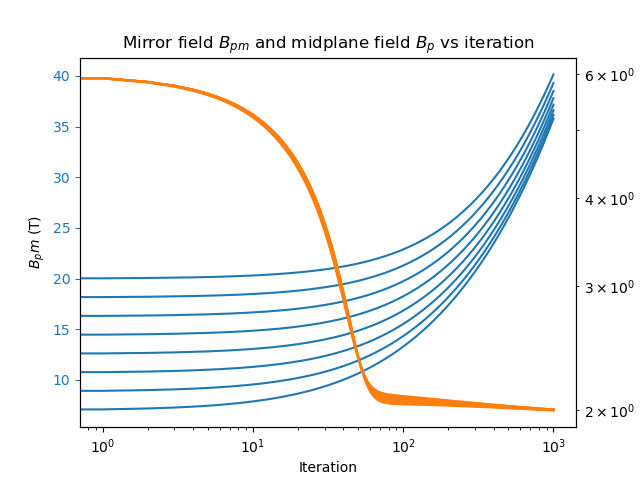

Text(0, 0.5, '$B_p$ (T)')

In [341]:
fig, ax = plt.subplots()
plt.title('Mirror field $B_{pm}$ and midplane field $B_p$ vs iteration')

ax.plot(np.array(simple_Q_opt.loop_values)[:, 6, 0:], color='#1f77b4')
# ax.set_xscale('log')
# ax.set_yscale('log')
ax.tick_params(colors="#1f77b4", axis='y')
ax.set_xlabel('Iteration')
ax.set_ylabel('$B_pm$ (T)')

ax2 = ax.twinx()
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.tick_params(colors="#ff7f0e", axis='y')
ax2.plot(np.array(simple_Q_opt.loop_values)[:, 9, 0:], color='#ff7f0e')
ax2.set_ylabel('$B_p$ (T)')

# plt.savefig('mirror_field_iteration_paper.pdf')

In [309]:
P_fus_plug_optimized = simple_Q_opt.evaluate_sympy_func(P_fus_plug * 1.0, iter_start=0, iter_end=1000, iter_step=1)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [305]:
P_fus_plug_DD_cat_optimized = simple_Q_opt.evaluate_sympy_func(P_fus_plug_DD_cat * 1.0, iter_start=0, iter_end=1000, iter_step=1)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [312]:
P_NBI_plug_optimized = simple_Q_opt.evaluate_sympy_func(P_NBI_plug * 1.0, iter_start=0, iter_end=1000, iter_step=1)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [311]:
np.array(P_fus_plug_optimized)[-1]

array([5.11720482, 5.17339138, 5.2432656 , 5.32698394, 5.42147846,
       5.52855939, 5.64821093, 5.77754564])

In [308]:
np.array(P_fus_plug_DD_cat_optimized)[-1]

array([0.35154871, 0.35511777, 0.35955291, 0.36482528, 0.37081835,
       0.37758273, 0.38510849, 0.39326301])

In [343]:
np.array(P_fus_plug_optimized)[-1]/(np.array(P_fus_plug_optimized)[-1] - np.array(P_fus_plug_DD_cat_optimized)[-1])

array([1.07376712, 1.07370228, 1.07362286, 1.07352149, 1.07341978,
       1.07330313, 1.07317138, 1.07303907])

In [201]:
Q_optimized = simple_Q_opt.evaluate_sympy_func(Q_plug * 1.0, iter_start=0, iter_end=1000, iter_step=1)

  0%|          | 0/1000 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


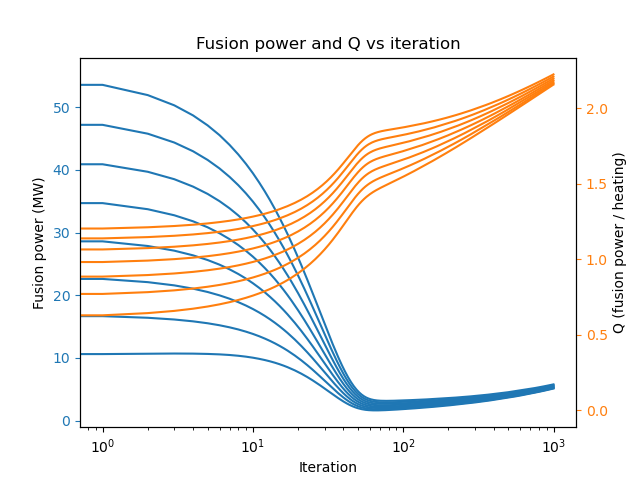

Text(0, 0.5, 'Q (fusion power / heating)')

In [340]:
# plt.figure()
# plt.plot(np.array(Q_optimized)[:], color="#1f77b4")
# plt.title('')
# plt.xlabel('Iteration')
# plt.ylabel('')
# plt.ylim(0.5, 2.3)
# plt.xscale('log')
# plt.savefig('Q_vs_iteration_paper.pdf')


fig, ax = plt.subplots()
ax.plot(np.array(P_fus_plug_optimized)[:], color='#1f77b4')
ax.set_xscale('log')
ax.tick_params(colors="#1f77b4", axis='y')
ax2 = ax.twinx()
ax2.set_xscale('log')
ax2.tick_params(colors="#ff7f0e", axis='y')
ax2.plot(np.array(Q_optimized)[:], color='#ff7f0e')
plt.title('Fusion power and Q vs iteration')
ax.set_xlabel('Iteration')
ax.set_ylabel('Fusion power (MW)')
ax2.set_ylabel('Q (fusion power / heating)')
# plt.savefig('Power_Q_vs_iteration_paper.pdf')

In [261]:
Ti_optimized = simple_Q_opt.evaluate_sympy_func(Ti * 1.0, iter_start=0, iter_end=1000, iter_step=1)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [262]:
Te_optimized = simple_Q_opt.evaluate_sympy_func(Te * 1.0, iter_start=0, iter_end=1000, iter_step=1)

  0%|          | 0/1000 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


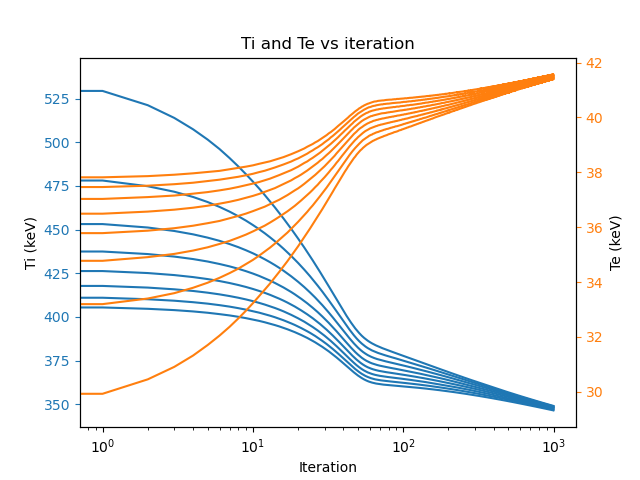

In [302]:
fig, ax = plt.subplots()
ax.plot(np.array(Ti_optimized)[:], color='#1f77b4')
ax.set_xscale('log')
ax.tick_params(colors="#1f77b4", axis='y')
ax2 = ax.twinx()
ax2.set_xscale('log')
ax2.tick_params(colors="#ff7f0e", axis='y')
ax2.plot(np.array(Te_optimized)[:], color='#ff7f0e')
plt.title('Ti and Te vs iteration')
ax.set_xlabel('Iteration')
ax.set_ylabel('Ti (keV)')
ax2.set_ylabel('Te (keV)')
# plt.savefig('Ti_Te_vs_iteration_paper.pdf')

In [348]:
frac_burnup_plug_optimized = simple_Q_opt.evaluate_sympy_func(2 * (Rx_plug_DT + Rx_plug_DD) / (2*(Rx_plug_DT + Rx_plug_DD) + dN_dt_plug), iter_start=0, iter_end=1000, iter_step=1)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [349]:
np.array(frac_burnup_plug_optimized[-1])

array([0.23639449, 0.2370146 , 0.23776882, 0.23865232, 0.23963957,
       0.24072845, 0.24190725, 0.24315632])

In [345]:
np.array(frac_burnup_plug_optimized[-1])

array([0.15478836, 0.15532054, 0.15596897, 0.15673018, 0.15758288,
       0.15852593, 0.1595499 , 0.16063841])